In [125]:
import os
import csv
import numpy as np
import pandas as pd
import requests
import lxml.html as lh
import unidecode
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# 1. Load the data

In [128]:
directory = './data/money-puck/'
data_total = [] 
count = 0
# iterate through money-puck directory
for filename in os.listdir(directory):
    file = os.path.join(directory, filename)
    if os.path.isfile(file):
        count += 1
        with open(file, newline='') as csvfile: 
            data_year = csv.reader(csvfile)
            # do not read in header more than once
            if count > 1:
                next(data_year, None)  # skip the headers
            else:
                pass
            # accumulate data in a list
            for row in data_year:
                # data_total.append(row)
                for idx, cell in enumerate(row):
                    # convert strings to integers or floats
                    if cell.isdigit():
                        row[idx] = int(cell)
                    else:
                        try:
                            row[idx] = float(cell)
                        except:
                            pass
                data_total.append(row)
    else:
        print("file does not exist")
        
print(f'number of datasets: {count}')
header = data_total[0] # take header
data_total = data_total[1:] # remove header

file does not exist
number of datasets: 16


In [130]:
# convert to dataframe
df1 = pd.DataFrame(data_total, columns=header)
df1.head()

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,unblocked_shot_attempts,xRebounds,rebounds,xFreeze,freeze,xOnGoal,ongoal,xPlayStopped,playStopped,xPlayContinuedInZone,playContinuedInZone,xPlayContinuedOutsideZone,playContinuedOutsideZone,flurryAdjustedxGoals,lowDangerShots,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties
0,8470140,2011,Kari Lehtonen,DAL,G,other,59,6237.0,10.55,7.0,201.0,7.45,7.0,22.70,15.0,108.21,104.0,2.02,0.0,59.31,59.0,45.51,57.0,9.97,109.0,29.0,11.0,3.34,3.67,3.54,3.0,3.0,1.0,52.0,0.0,0.0
1,8470140,2011,Kari Lehtonen,DAL,G,all,59,208609.0,135.05,136.0,3356.0,119.14,129.0,404.19,371.0,1744.25,1739.0,52.84,43.0,996.42,849.0,740.86,903.0,129.67,1941.0,396.0,116.0,51.81,48.15,35.09,52.0,52.0,32.0,903.0,0.0,0.0
2,8470140,2011,Kari Lehtonen,DAL,G,5on5,59,164862.0,92.55,96.0,2476.0,81.30,88.0,309.53,287.0,1286.34,1275.0,42.45,33.0,723.25,609.0,556.37,673.0,89.85,1443.0,292.0,70.0,39.04,35.50,18.00,41.0,37.0,18.0,671.0,0.0,0.0
3,8470140,2011,Kari Lehtonen,DAL,G,4on5,59,20811.0,29.02,32.0,607.0,28.55,34.0,66.47,63.0,311.23,322.0,1.38,0.0,201.44,171.0,105.79,134.0,26.94,342.0,68.0,32.0,7.98,8.11,12.94,7.0,12.0,13.0,165.0,0.0,0.0
4,8470140,2011,Kari Lehtonen,DAL,G,5on4,59,16699.0,2.55,1.0,63.0,1.53,0.0,4.67,4.0,34.19,35.0,6.61,10.0,10.19,7.0,31.05,38.0,2.55,43.0,5.0,3.0,1.30,0.64,0.61,1.0,0.0,0.0,12.0,0.0,0.0


In [132]:
print(f'sample size: {sum(df1['situation']=='all')}')
print(f'numer of dimensions: {df1.shape[1]}')
years = np.sort(df1['season'].unique())
print(f'season range: {years.min()}-{years.max()}')

sample size: 1501
numer of dimensions: 36
season range: 2008-2023


# 2. Scrape Missing Data

In [135]:
# Write a function to scrape the data from nhl-reference.com
# fetch name, team, age, wins
def season_scraper(url, year):
    # Get the page content
    page = requests.get(url)
    doc = lh.fromstring(page.content)
    # Extract the table from page
    tr_elements = doc.xpath('//tr')
    
    tr_elements.pop(0)
    players = []
    # Read the rest of rows
    for row in tr_elements:
        player = []
        # The table on the website repeats its column names every 20 rows or so
        # Let's check for those and skip them
        if row[0].text_content() == 'Rk':
            continue
        if row.get('class') == "partial_table":
            continue
        else:
            player.append(year) # append season

            # find names
            age_element = row[1].xpath('.//a')
            for a in age_element:
                player.append(a.text)
                
            player.append(int(row[2].text)) # append age (pull as age)
            
            # check if row is accumulated stats
            if row[3].text == 'TOT': 
                player.append(row[3].text) # append 'TOT'
            else:
                tm_element = row[3].xpath('.//a')
                for tm in tm_element:
                    player.append(tm.text) # append team id
            player.append(row[4].text) # append number of GP
            player.append(row[6].text) # append number of wins
            
                
            players.append(player)
    return players

In [137]:
all_ages = []
for year in years:
    url = f'https://www.hockey-reference.com/leagues/NHL_{year+1}_goalies.html'
    all_ages.append(season_scraper(url, year))

all_players = []
for i, season in enumerate(all_ages):
    for player in season:
        all_players.append(player)

In [138]:
# convert to dataframe
df2 = pd.DataFrame(data=all_players, columns=['season','name','age','team', 'games_played', 'wins'])
df2.head()

,season,name,age,team,games_played,wins
0,2008,Craig Anderson,27,FLA,31,15
1,2008,Alex Auld,28,OTT,43,16
2,2008,Niklas Bäckström,30,MIN,71,37
3,2008,Martin Biron,31,PHI,55,29
4,2008,Ben Bishop,22,STL,6,1


# 3. Data Merging and Cleaning

In [141]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7505 entries, 0 to 7504
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   playerId                   7505 non-null   int64  
 1   season                     7505 non-null   int64  
 2   name                       7505 non-null   object 
 3   team                       7505 non-null   object 
 4   position                   7505 non-null   object 
 5   situation                  7505 non-null   object 
 6   games_played               7505 non-null   int64  
 7   icetime                    7505 non-null   float64
 8   xGoals                     7505 non-null   float64
 9   goals                      7505 non-null   float64
 10  unblocked_shot_attempts    7505 non-null   float64
 11  xRebounds                  7505 non-null   float64
 12  rebounds                   7505 non-null   float64
 13  xFreeze                    7505 non-null   float

In [143]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   season        1503 non-null   int64 
 1   name          1503 non-null   object
 2   age           1503 non-null   int64 
 3   team          1503 non-null   object
 4   games_played  1503 non-null   object
 5   wins          1497 non-null   object
dtypes: int64(2), object(4)
memory usage: 70.6+ KB


In [145]:
# drop unnecessary columns
df1 = df1.drop(['playerId', 'position', 'penalityMinutes', 'penalties'], axis=1)
df1 = df1[df1['situation'] == 'all']
df1 = df1.drop('situation',axis=1).reset_index(drop=True)

In [147]:
# drop null values from df2 (sports reference)
df2 = df2.dropna()

In [149]:
# remove string accents
df2['name'] = df2['name'].apply(lambda x: unidecode.unidecode(x))

In [151]:
# change gp and wins to integers
df2.loc[:,'wins']                = df2.loc[:,'wins'].astype(str).astype(int)
df2.loc[:,'games_played']        = df2.loc[:,'games_played'].astype(str).astype(int)

In [153]:
# modify team ids for consistency
def change_team(x):
    """normalize team IDs
    """
    if x == 'S.J':
        return 'SJS'
    if x == 'T.B':
        return 'TBL'
    if x == 'N.J':
        return 'NJD'
    if x == 'L.A':
        return 'LAK'
    else:
        return x
df1.loc[:,'team'] = df1['team'].apply(change_team)

In [155]:
# check/inspect number of rows (only for 'all')
print(f'sample size: {df1.shape[0]}') # only looking at aggregated season totals 
print(f'number of unique goalies: {len(df1['name'].unique())}')

sample size: 1501
number of unique goalies: 318


In [157]:
# check/inspect number of rows
print(f'sample size: {df2.shape[0]}')
print(f'number of unique goalies: {len(df2['name'].unique())}')

sample size: 1497
number of unique goalies: 313


In [159]:
# check for duplicate names
def check_names(x):
    '''Return 1 (true) if all names only appear once. Otherwise, return 0 (false). 
    '''
    names = x
    dict_names = dict.fromkeys(set(names), 0)
    for name in names:
        dict_names[name] = dict_names[name] + 1
    return all(occur == 1 for occur in dict_names.values())
# check to see if all seasons exist without duplicate names (should return true)
names_by_season = df1.groupby('season')['name'].apply(list).reset_index() # check filtered dataframe
print(names_by_season['name'].apply(check_names))
# there are two goalies with the same name in season 2022-2023
# strategy: join on season, name, and games_played
# not joining on 'team' b/c some goalies were traded mid-season 
# and are denoted 'TOT'

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14    False
15     True
Name: name, dtype: bool


In [161]:
# merge dataframes on season and name 
df   = df2.merge(df1, on=['season', 'name', 'games_played'], how='inner', suffixes=('_sportsRef', '_moneyPuck')).sort_values(by='season')
df   = df.drop('team_sportsRef', axis=1) # keep only team name from money puck
df   = df.rename(columns={'team_moneyPuck' : 'team'})
df.head()

,season,name,age,games_played,wins,team,icetime,xGoals,goals,unblocked_shot_attempts,xRebounds,rebounds,xFreeze,freeze,xOnGoal,ongoal,xPlayStopped,playStopped,xPlayContinuedInZone,playContinuedInZone,xPlayContinuedOutsideZone,playContinuedOutsideZone,flurryAdjustedxGoals,lowDangerShots,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts
0,2008,Craig Anderson,27,31,15,FLA,98154.0,83.98,74.0,1689.0,66.46,65.0,209.85,241.0,941.05,977.0,23.47,16.0,524.51,410.0,392.14,492.0,80.90,983.0,252.0,76.0,29.14,30.77,24.07,24.0,29.0,21.0,378.0
57,2008,Carey Price,21,52,23,MTL,180336.0,135.94,143.0,2840.0,101.03,113.0,333.95,326.0,1468.55,1513.0,45.39,54.0,803.69,638.0,613.03,822.0,130.36,1570.0,370.0,137.0,45.83,45.34,44.77,44.0,45.0,54.0,763.0
56,2008,Justin Pogge,22,7,1,TOR,22302.0,14.75,27.0,312.0,10.90,4.0,35.28,26.0,165.50,173.0,6.17,10.0,92.51,72.0,77.46,102.0,14.56,176.0,46.0,14.0,4.65,5.58,4.52,14.0,8.0,5.0,76.0
55,2008,Ondrej Pavelec,21,12,3,ATL,35965.0,27.39,36.0,514.0,19.35,17.0,64.44,52.0,287.63,301.0,7.80,4.0,161.19,139.0,118.53,151.0,26.20,305.0,75.0,23.0,9.17,8.73,9.48,13.0,13.0,10.0,111.0
54,2008,Chris Osgood,36,46,26,DET,159763.0,117.96,137.0,2004.0,78.09,77.0,257.23,247.0,1170.13,1208.0,49.36,56.0,636.34,495.0,485.41,630.0,112.62,1186.0,318.0,119.0,36.97,38.61,42.38,43.0,43.0,51.0,381.0


In [163]:
cols = df.columns.tolist() 
cols = cols[:3] + cols[5:6] + cols[3:5] + cols[6:] # rearrange columns
df = df[cols]

In [165]:
df.head()

,season,name,age,team,games_played,wins,icetime,xGoals,goals,unblocked_shot_attempts,xRebounds,rebounds,xFreeze,freeze,xOnGoal,ongoal,xPlayStopped,playStopped,xPlayContinuedInZone,playContinuedInZone,xPlayContinuedOutsideZone,playContinuedOutsideZone,flurryAdjustedxGoals,lowDangerShots,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts
0,2008,Craig Anderson,27,FLA,31,15,98154.0,83.98,74.0,1689.0,66.46,65.0,209.85,241.0,941.05,977.0,23.47,16.0,524.51,410.0,392.14,492.0,80.90,983.0,252.0,76.0,29.14,30.77,24.07,24.0,29.0,21.0,378.0
57,2008,Carey Price,21,MTL,52,23,180336.0,135.94,143.0,2840.0,101.03,113.0,333.95,326.0,1468.55,1513.0,45.39,54.0,803.69,638.0,613.03,822.0,130.36,1570.0,370.0,137.0,45.83,45.34,44.77,44.0,45.0,54.0,763.0
56,2008,Justin Pogge,22,TOR,7,1,22302.0,14.75,27.0,312.0,10.90,4.0,35.28,26.0,165.50,173.0,6.17,10.0,92.51,72.0,77.46,102.0,14.56,176.0,46.0,14.0,4.65,5.58,4.52,14.0,8.0,5.0,76.0
55,2008,Ondrej Pavelec,21,ATL,12,3,35965.0,27.39,36.0,514.0,19.35,17.0,64.44,52.0,287.63,301.0,7.80,4.0,161.19,139.0,118.53,151.0,26.20,305.0,75.0,23.0,9.17,8.73,9.48,13.0,13.0,10.0,111.0
54,2008,Chris Osgood,36,DET,46,26,159763.0,117.96,137.0,2004.0,78.09,77.0,257.23,247.0,1170.13,1208.0,49.36,56.0,636.34,495.0,485.41,630.0,112.62,1186.0,318.0,119.0,36.97,38.61,42.38,43.0,43.0,51.0,381.0


In [167]:
# check/inspect number of rows (only for 'all')
print(f'sample size: {df.shape[0]}') # only looking at aggregated season totals 
print(f'number of unique goalies: {len(df['name'].unique())}')

sample size: 1434
number of unique goalies: 299


## 4. Fix discrepencies caused by short seasons

In [170]:
cumulative_features = df.columns[4:]
for col in cumulative_features:
    if col == 'saves on shots on goal' or col == 'goals against':
        df.loc[df['season'] == 2012, col] = df.loc[df['season'] == 2012, col]*(82/48)
        df.loc[df['season'] == 2020, col] = df.loc[df['season'] == 2020, col]*(82/56)
    else:
        df.loc[df['season'] == 2012, col] = (df.loc[df['season'] == 2012, col]*(82/48)).apply(int)
        df.loc[df['season'] == 2020, col] = (df.loc[df['season'] == 2020, col]*(82/56)).apply(int)

## 5. Compute Advanced Metrics 

In [173]:
# source: money puck
df_copy = df # make a copy of dataframe

df_copy.loc[:,'sv% on unblocked shots']                                   = (df_copy.unblocked_shot_attempts - df_copy.goals)/df_copy.unblocked_shot_attempts
df_copy.loc[:,'xSV% on unblocked shots']                                  = (df_copy.unblocked_shot_attempts - df_copy.xGoals)/df_copy.unblocked_shot_attempts
df_copy.loc[:,'sv% above expected on unblocked shots']                    = df_copy.loc[:,'sv% on unblocked shots'] - df_copy.loc[:,'xSV% on unblocked shots']
df_copy.loc[:,'sv% on shots on goal']                                     = (df_copy.ongoal - df_copy.goals)/df_copy.ongoal
df_copy.loc[:,'xSV% on shots on goal']                                    = (df_copy.ongoal - df_copy.xGoals)/df_copy.ongoal
df_copy.loc[:,'sv% above expected on shots on goal']                      = df_copy.loc[:,'sv% on shots on goal'] - df_copy.loc[:,'xSV% on shots on goal']
df_copy.loc[:,'gaa per 60 min']                                           = (df_copy.goals/df_copy.icetime)*(60**2)
df_copy.loc[:,'xGAA per 60 min']                                          = (df_copy.xGoals/df_copy.icetime)*(60**2)
df_copy.loc[:,'gsaa per 60 min']                                          = df_copy.loc[:,'xGAA per 60 min'] - df_copy.loc[:,'gaa per 60 min']
df_copy.loc[:,'war']                                                      = (df_copy.xGoals - df_copy.goals)/6
df_copy.loc[:,'saves on shots on goal']                                   = df_copy.ongoal - df_copy.goals
df_copy.loc[:,'rebounds per save']                                        = df.rebounds/df_copy['saves on shots on goal']
df_copy.loc[:,'freezes per save']                                         = df.freeze/df_copy['saves on shots on goal']
df_copy.loc[:,'goals against']                                            = df.goals
df_copy.loc[:,'saves on unblocked shot attempts']                         = df_copy.unblocked_shot_attempts - df_copy.goals
df_copy.loc[:,'% of shot attempts blocked by teammates']                  = df_copy.blocked_shot_attempts / (df_copy.blocked_shot_attempts + df_copy.unblocked_shot_attempts)
df_copy.loc[:,'% of unblocked shot attempts against on goal']             = df_copy.ongoal / df_copy.unblocked_shot_attempts
df_copy.loc[:,'expected % of unblocked shot attempts against on goal']    = df_copy.xOnGoal / df_copy.unblocked_shot_attempts
df_copy.loc[:,'on goal % above expected']                                 = df_copy.loc[:,'% of unblocked shot attempts against on goal'] - df_copy.loc[:,'expected % of unblocked shot attempts against on goal']
df_copy.loc[:,'low danger unblocked shot attempt sv%']                    = (df_copy.lowDangerShots - df_copy.lowDangerGoals) / df_copy.lowDangerShots
df_copy.loc[:,'xLow danger unblocked shot attempt sv%']                   = (df_copy.lowDangerShots - df_copy.lowDangerxGoals) / df_copy.lowDangerShots
df_copy.loc[:,'low danger unblocked shot attempt sv% above expected']     = df_copy.loc[:,'low danger unblocked shot attempt sv%'] - df_copy.loc[:,'xLow danger unblocked shot attempt sv%'] 
df_copy.loc[:,'medium danger unblocked shot attempt sv%']                 = (df_copy.mediumDangerShots - df_copy.mediumDangerGoals) / df_copy.mediumDangerShots
df_copy.loc[:,'xMedium danger unblocked shot attempt sv%']                = (df_copy.mediumDangerShots - df_copy.mediumDangerxGoals) / df_copy.mediumDangerShots
df_copy.loc[:,'medium danger unblocked shot attempt sv% above expected']  = df_copy.loc[:,'medium danger unblocked shot attempt sv%'] - df_copy.loc[:,'xMedium danger unblocked shot attempt sv%'] 
df_copy.loc[:,'high danger unblocked shot attempt sv%']                   = (df_copy.highDangerShots - df_copy.highDangerGoals) / df_copy.highDangerShots
df_copy.loc[:,'xHigh danger unblocked shot attempt sv%']                  = (df_copy.highDangerShots - df_copy.highDangerxGoals) / df_copy.highDangerShots
df_copy.loc[:,'high danger unblocked shot attempt sv% above expected']    = df_copy.loc[:,'high danger unblocked shot attempt sv%'] - df_copy.loc[:,'xHigh danger unblocked shot attempt sv%']
df_copy.loc[:,'corsi']                                                    = df_copy.loc[:,'ongoal'] + df_copy.loc[:,'blocked_shot_attempts'] + (df_copy.unblocked_shot_attempts - df_copy.ongoal)
df_copy.loc[:,'fenwick']                                                  = df_copy.loc[:,'unblocked_shot_attempts']

In [175]:
# get rid of raw data and expectations
df_copy = df_copy.drop(['xGoals', 'goals', 'xRebounds', 'rebounds', 'xFreeze', 'freeze', 
              'xOnGoal', 'xPlayStopped', 'ongoal', 'unblocked_shot_attempts', 'blocked_shot_attempts', 'playStopped', 'xPlayContinuedInZone', 'playContinuedInZone',
              'xPlayContinuedOutsideZone', 'playContinuedOutsideZone', 'flurryAdjustedxGoals', 'lowDangerShots',
              'mediumDangerShots', 'highDangerShots', 'lowDangerxGoals', 'mediumDangerxGoals', 'highDangerxGoals',
              'lowDangerGoals','mediumDangerGoals', 'highDangerGoals','xSV% on unblocked shots', 'xSV% on shots on goal', 
              'xGAA per 60 min', 'expected % of unblocked shot attempts against on goal',
              'xLow danger unblocked shot attempt sv%', 'xMedium danger unblocked shot attempt sv%', 
              'xHigh danger unblocked shot attempt sv%', 'high danger unblocked shot attempt sv%'], axis=1)

In [177]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1434 entries, 0 to 1433
Data columns (total 29 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   season                                                   1434 non-null   int64  
 1   name                                                     1434 non-null   object 
 2   age                                                      1434 non-null   int64  
 3   team                                                     1434 non-null   object 
 4   games_played                                             1434 non-null   object 
 5   wins                                                     1434 non-null   object 
 6   icetime                                                  1434 non-null   float64
 7   sv% on unblocked shots                                   1432 non-null   float64
 8   sv% above expected on unblocked s

In [179]:
# drop rows with null values
df_copy =  df_copy.dropna()

## 6. Check Outliers

In [182]:
df_copy.describe()

,season,age,icetime,sv% on unblocked shots,sv% above expected on unblocked shots,sv% on shots on goal,sv% above expected on shots on goal,gaa per 60 min,gsaa per 60 min,war,saves on shots on goal,rebounds per save,freezes per save,goals against,saves on unblocked shot attempts,% of shot attempts blocked by teammates,% of unblocked shot attempts against on goal,on goal % above expected,low danger unblocked shot attempt sv%,low danger unblocked shot attempt sv% above expected,medium danger unblocked shot attempt sv%,medium danger unblocked shot attempt sv% above expected,high danger unblocked shot attempt sv% above expected,corsi,fenwick
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,2015.879161,28.039797,100000.450796,0.947648,-0.003724,0.903624,-0.006561,2.903483,-0.182620,-0.103262,764.682344,0.083770,0.247924,75.125181,1480.924747,0.198334,0.542786,0.003521,0.967622,-0.003440,0.869900,-0.009538,-0.019168,1947.997106,1556.049928
std,4.632850,4.531874,72856.114050,0.017803,0.016161,0.031092,0.029005,0.879706,0.836094,1.701060,561.552115,0.030415,0.048144,52.515225,1085.690298,0.022719,0.040939,0.028035,0.016647,0.016262,0.065092,0.064373,0.150273,1427.667979,1136.947022
min,2008.000000,19.000000,753.000000,0.769231,-0.166154,0.571429,-0.277500,0.000000,-8.797822,-6.815000,4.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.322581,-0.170968,0.777778,-0.198889,0.000000,-0.900000,-1.000000,9.000000,8.000000
25%,2012.000000,25.000000,31936.500000,0.943734,-0.007341,0.895948,-0.013539,2.446757,-0.406929,-1.010833,251.250000,0.067469,0.220570,27.000000,479.250000,0.188053,0.520876,-0.010270,0.963069,-0.007355,0.855556,-0.023373,-0.058783,627.250000,512.500000
50%,2016.000000,28.000000,91713.000000,0.950538,-0.001104,0.908505,-0.002057,2.778728,-0.061700,-0.175000,702.500000,0.079805,0.246502,69.000000,1357.500000,0.199156,0.540557,0.003930,0.970175,-0.000901,0.877252,-0.001905,-0.003984,1782.000000,1432.500000
75%,2020.000000,31.000000,157986.750000,0.955819,0.003335,0.917838,0.006274,3.162948,0.188280,0.624167,1215.500000,0.096039,0.271920,119.000000,2374.000000,0.210563,0.562629,0.017915,0.975169,0.003902,0.894737,0.015627,0.048564,3115.500000,2500.750000
max,2023.000000,42.000000,267541.000000,1.000000,0.049048,1.000000,0.105556,12.253233,4.449664,7.778333,2191.000000,0.333333,0.545455,209.000000,4266.000000,0.280000,0.923077,0.176154,1.000000,0.038000,1.000000,0.170000,0.620000,5509.000000,4450.000000


In [184]:
# outliers may be caused by small sample sizes. 
# drop all goalies with less than 18 games played
df_filtered = df_copy[df_copy['games_played'] >= 18]
df_filtered.shape

(922, 29)

In [186]:
df_filtered.describe()

,season,age,icetime,sv% on unblocked shots,sv% above expected on unblocked shots,sv% on shots on goal,sv% above expected on shots on goal,gaa per 60 min,gsaa per 60 min,war,saves on shots on goal,rebounds per save,freezes per save,goals against,saves on unblocked shot attempts,% of shot attempts blocked by teammates,% of unblocked shot attempts against on goal,on goal % above expected,low danger unblocked shot attempt sv%,low danger unblocked shot attempt sv% above expected,medium danger unblocked shot attempt sv%,medium danger unblocked shot attempt sv% above expected,high danger unblocked shot attempt sv% above expected,corsi,fenwick
count,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,2015.837310,28.918655,139644.843818,0.951282,-0.000748,0.909727,-0.001330,2.732563,-0.039329,-0.016090,1068.451193,0.082337,0.246167,104.004338,2069.598698,0.200570,0.539978,0.003175,0.970052,-0.001083,0.876763,-0.002194,-0.001059,2722.069414,2173.603037
std,4.637523,4.276657,55619.646146,0.006673,0.005871,0.011876,0.010826,0.415231,0.326203,2.012637,432.456185,0.019238,0.031321,39.135861,833.416757,0.014805,0.026641,0.017821,0.006746,0.006585,0.023328,0.023337,0.064708,1096.044932,870.258906
min,2008.000000,20.000000,43707.000000,0.926829,-0.021708,0.871084,-0.038363,1.571402,-1.128763,-6.815000,342.000000,0.035948,0.144762,32.000000,642.000000,0.153542,0.434343,-0.054181,0.940959,-0.027392,0.777108,-0.103614,-0.229636,848.000000,691.000000
25%,2012.000000,26.000000,91679.500000,0.947121,-0.004347,0.902165,-0.008202,2.436052,-0.237296,-1.269167,702.250000,0.069462,0.224908,69.000000,1357.250000,0.190508,0.522689,-0.008668,0.965927,-0.005066,0.861472,-0.016854,-0.040842,1781.500000,1432.250000
50%,2016.000000,28.000000,132689.000000,0.952092,-0.000393,0.910766,-0.000750,2.688084,-0.021539,-0.115000,1013.500000,0.078884,0.246456,100.000000,1959.000000,0.200043,0.539747,0.003324,0.970783,-0.000457,0.878827,-0.000820,0.000000,2561.000000,2065.000000
75%,2020.000000,32.000000,185955.250000,0.955937,0.003195,0.917893,0.006103,3.000232,0.183936,1.169167,1416.500000,0.091875,0.266338,137.000000,2779.750000,0.210422,0.558270,0.015302,0.974785,0.003390,0.892155,0.013072,0.041245,3662.250000,2915.750000
max,2023.000000,42.000000,267541.000000,0.969296,0.015798,0.941176,0.029342,4.244251,0.883700,7.778333,2191.000000,0.173623,0.349123,209.000000,4266.000000,0.258427,0.618257,0.079497,0.990453,0.021098,0.943662,0.062868,0.174048,5509.000000,4450.000000


Text(0.5, 1.0, 'Distribution of Wins')

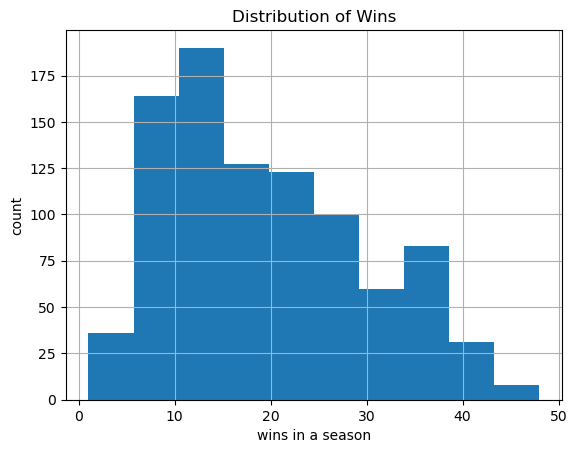

In [188]:
df_filtered['wins'].hist()
plt.xlabel('wins in a season')
plt.ylabel('count')
plt.title('Distribution of Wins')

## 7. Compute Win Probability for a Given Season

In [206]:
# calculate percentage of wins (i.e., wins / games_played)
df_filtered.loc[:,'wins']      = df_copy.loc[:,'wins'].astype(str).astype(int)
df_filtered.loc[:,'win_prob'] = df_copy.wins / df_copy.games_played

In [208]:
df_filtered.head()

,season,name,age,team,games_played,wins,icetime,sv% on unblocked shots,sv% above expected on unblocked shots,sv% on shots on goal,sv% above expected on shots on goal,gaa per 60 min,gsaa per 60 min,war,saves on shots on goal,rebounds per save,freezes per save,goals against,saves on unblocked shot attempts,% of shot attempts blocked by teammates,% of unblocked shot attempts against on goal,on goal % above expected,low danger unblocked shot attempt sv%,low danger unblocked shot attempt sv% above expected,medium danger unblocked shot attempt sv%,medium danger unblocked shot attempt sv% above expected,high danger unblocked shot attempt sv% above expected,corsi,fenwick,win_prob
0,2008,Craig Anderson,27,FLA,31,15,98154.0,0.956187,0.005909,0.924258,0.010215,2.714102,0.366037,1.663333,903.0,0.071982,0.266888,74.0,1615.0,0.182874,0.578449,0.021285,0.975585,0.005229,0.884921,0.007024,0.040395,2067.0,1689.0,0.483871
57,2008,Carey Price,21,MTL,52,23,180336.0,0.949648,-0.002486,0.905486,-0.004666,2.854671,-0.140937,-1.176667,1370.0,0.082482,0.237956,143.0,2697.0,0.211768,0.532746,0.015651,0.971975,0.001166,0.878378,0.000919,-0.067372,3603.0,2840.0,0.442308
54,2008,Chris Osgood,36,DET,46,26,159763.0,0.931637,-0.009501,0.886589,-0.015762,3.087073,-0.429036,-3.173333,1071.0,0.071895,0.230626,137.0,1867.0,0.159748,0.602794,0.018897,0.963744,-0.005084,0.864780,-0.013805,-0.072437,2385.0,2004.0,0.565217
52,2008,Antero Niittymaki,28,PHI,32,15,108255.0,0.952868,0.000619,0.912355,0.001151,2.760150,0.036248,0.181667,864.0,0.086806,0.237269,83.0,1678.0,0.200272,0.537763,0.006053,0.967710,-0.002671,0.881517,0.001517,0.040345,2202.0,1761.0,0.46875
59,2008,Karri Ramo,22,TBL,24,4,82314.0,0.942039,-0.007996,0.895334,-0.014439,3.630002,-0.500765,-1.908333,710.0,0.078873,0.257746,83.0,1349.0,0.195506,0.553771,0.020615,0.974453,0.003942,0.850000,-0.031700,-0.134677,1780.0,1432.0,0.166667


## 8. Compute Target Variable

Define goalie improvement by: 
- If goalie has next season data: improvement_next_season(year) = win_prob(year+1) - win_prob(year)

- If goalie missed a season: improvement_next_season(year) = win_prib(year+2) - win_prob(year)

In [212]:
# Function to calculate improvement
def calculate_diff_with_next_year(df, col):
    diff = dict()
    for index, row in df.iterrows():
        season = row['season']
        # Check to see if stats for next year exists
        if season+1 in df['season'].values:
            next_year_value = df.loc[df['season'] == season + 1, col].iloc[0]
            diff[season] = float(next_year_value - row[col])
        elif season+2 in df['season'].values:
            next_year_value = df.loc[df['season'] == season + 2, col].iloc[0]
            diff[season] = float(next_year_value - row[col])
        else:
            diff[season] = np.nan
    return pd.Series(diff)
    
# Calculate improvement and create DataFrame
improvement = df_filtered.groupby('name').apply(calculate_diff_with_next_year, col='win_prob', include_groups=False)
improvement = pd.DataFrame(improvement).reset_index()
improvement.columns = ['name', 'season', 'improvement']

# Merge into the main dataset
data = pd.merge(df_filtered, improvement, on=['name', 'season'], how='inner')
# keep version of dataset with null values
data.to_csv('./data/goalie_stats_wNull.csv', index=False)
# Drop years without target values
data.dropna(inplace=True)

In [214]:
data.head()

,season,name,age,team,games_played,wins,icetime,sv% on unblocked shots,sv% above expected on unblocked shots,sv% on shots on goal,sv% above expected on shots on goal,gaa per 60 min,gsaa per 60 min,war,saves on shots on goal,rebounds per save,freezes per save,goals against,saves on unblocked shot attempts,% of shot attempts blocked by teammates,% of unblocked shot attempts against on goal,on goal % above expected,low danger unblocked shot attempt sv%,low danger unblocked shot attempt sv% above expected,medium danger unblocked shot attempt sv%,medium danger unblocked shot attempt sv% above expected,high danger unblocked shot attempt sv% above expected,corsi,fenwick,win_prob,improvement
0,2008,Craig Anderson,27,FLA,31,15,98154.0,0.956187,0.005909,0.924258,0.010215,2.714102,0.366037,1.663333,903.0,0.071982,0.266888,74.0,1615.0,0.182874,0.578449,0.021285,0.975585,0.005229,0.884921,0.007024,0.040395,2067.0,1689.0,0.483871,0.051340
1,2008,Carey Price,21,MTL,52,23,180336.0,0.949648,-0.002486,0.905486,-0.004666,2.854671,-0.140937,-1.176667,1370.0,0.082482,0.237956,143.0,2697.0,0.211768,0.532746,0.015651,0.971975,0.001166,0.878378,0.000919,-0.067372,3603.0,2840.0,0.442308,-0.125235
2,2008,Chris Osgood,36,DET,46,26,159763.0,0.931637,-0.009501,0.886589,-0.015762,3.087073,-0.429036,-3.173333,1071.0,0.071895,0.230626,137.0,1867.0,0.159748,0.602794,0.018897,0.963744,-0.005084,0.864780,-0.013805,-0.072437,2385.0,2004.0,0.565217,-0.260870
3,2008,Antero Niittymaki,28,PHI,32,15,108255.0,0.952868,0.000619,0.912355,0.001151,2.760150,0.036248,0.181667,864.0,0.086806,0.237269,83.0,1678.0,0.200272,0.537763,0.006053,0.967710,-0.002671,0.881517,0.001517,0.040345,2202.0,1761.0,0.46875,-0.040179
5,2008,Ryan Miller,28,BUF,59,34,202395.0,0.954659,-0.001651,0.918218,-0.002978,2.579115,-0.093915,-0.880000,1628.0,0.053440,0.226658,145.0,3053.0,0.189764,0.554409,0.016701,0.969649,-0.002496,0.886836,0.006397,-0.031238,3947.0,3198.0,0.576271,0.017932


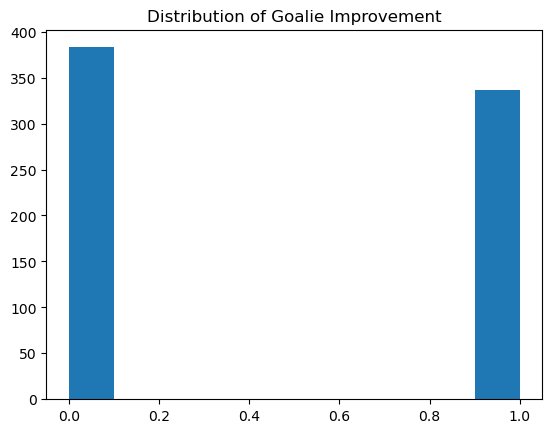

In [216]:
# data quality check
improvement_level = np.where(data['improvement'] < 0, 0, 1)
plt.hist(improvement_level)
plt.title('Distribution of Goalie Improvement')
plt.show()

## 9. Data Export

In [219]:
data.to_csv('./data/goalie_stats.csv', index=False)